# eICU Experiments

In [1]:
import tensorflow as tf
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import seaborn as sns
import random

In [ ]:
try:
    import tensorflow.compat.v1 as tf 
    tf.disable_v2_behavior()
except:
    import tensorflow as tf

Follow Read-me instruction to download the medical data.

After having downloaded the data in '../data/eICU_data.csv', upload the data:

In [3]:
def get_data(test=True):
    hf = h5py.File('../data/eICU_data.csv', 'r')
    data_total = np.array(hf.get('x'))
    endpoints_total = np.array(hf.get('y'))
    hf.close()
    data_train, data_val, y_train, endpoints_total_val = train_test_split(data_total[:int(len(data_total) * 0.85)],
                                                                          endpoints_total[:int(len(data_total) * 0.85)],
                                                                          test_size=0.20,
                                                                          random_state=42)
    if test:
        data_val = data_total[int(len(data_total) * 0.85):]
        endpoints_total_val = endpoints_total[int(len(data_total) * 0.85):]
    return data_train, data_val, y_train, endpoints_total_val

In [4]:
def batch_generator(data_train, data_val, endpoints_total_val, batch_size, mode="train"):
    while True:
        if mode == "train":
            for i in range(len(data_train) // batch_size):
                time_series = data_train[i * batch_size: (i + 1) * batch_size]
                yield time_series, i
        elif mode == "val":
            for i in range(len(data_val) // batch_size):
                time_series = data_val[i * batch_size: (i + 1) * batch_size]
                time_series_endpoint = endpoints_total_val[i * batch_size: (i + 1) * batch_size]
                yield time_series, time_series_endpoint, i
        else:
            raise ValueError("The mode has to be in {train, val}")

Insert the name of the job in ex_name:

In [6]:
ex_name=""
#example ex_name="hyperopt_LSTM_100_16-16_2020-06-04_d2c5a"

Get the data:

In [7]:
batch_size=128
modelpath = "../models/{}/{}".format(ex_name, ex_name)
data_train, data_val, endpoints_total_train, endpoints_total_val = get_data(test=True)

## Create heat-maps, trajectories and probability distributions

In [8]:
som_dim = [16,16]
latent_dim=20

In [9]:
val_gen = batch_generator(data_train, data_val, endpoints_total_val, 300, mode="val")

In [10]:
num_batches = len(data_val) // 300
tf.reset_default_graph()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath+".meta")
    saver.restore(sess, modelpath)
    graph = tf.get_default_graph()
    k = graph.get_tensor_by_name("k/k:0")
    z_e = graph.get_tensor_by_name("z_e_sample/z_e:0")
    x = graph.get_tensor_by_name("inputs/x:0")
    is_training = graph.get_tensor_by_name("is_training/is_training:0")
    graph = tf.get_default_graph()
    z_e_p = graph.get_tensor_by_name("prediction/next_state/input_lstm:0")
    q = graph.get_tensor_by_name("q/distribution/q:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")
    reconstruction = graph.get_tensor_by_name("reconstruction_e/x_hat:0")
    
    print("Evaluation...")
    test_k_all = []
    labels_val_all = []
    z_e_all=[]
    z_q_all = []
    qq = []
    for i in range(num_batches):
            batch_data, batch_labels, ii = next(val_gen)
            f_dic = {x: batch_data}
            test_k_all.extend(sess.run(k, feed_dict=f_dic))
            labels_val_all.extend(batch_labels)
            z_q_all.extend(sess.run(q, feed_dict=f_dic))
            qq.extend(sess.run(q, feed_dict=f_dic))
            z_e_all.extend(sess.run(z_e, feed_dict=f_dic))
    labels_val_all = np.array(labels_val_all)
    k_all = np.array(test_k_all)
    qq = np.array(qq)
    labels_val_all = np.reshape(labels_val_all, (-1, labels_val_all.shape[-1]))
    NMI_24 = metrics.normalized_mutual_info_score(labels_val_all[:, 3], k_all)
    NMI_12 = metrics.normalized_mutual_info_score(labels_val_all[:, 2], k_all)
    NMI_6 = metrics.normalized_mutual_info_score(labels_val_all[:, 1], k_all)
    NMI_1 = metrics.normalized_mutual_info_score(labels_val_all[:, 0], k_all)
    
    embb = sess.run(embeddings, feed_dict={x: data_val})

INFO:tensorflow:Restoring parameters from ../models/hyperopt_LSTM_100_16-16_2020-06-04_d2c5a/hyperopt_LSTM_100_16-16_2020-06-04_d2c5a
Evaluation...


Get the labels:

In [11]:
labels_12 = labels_val_all[:,2]
labels_1 = labels_val_all[:,0]
labels_6 = labels_val_all[:,1]
labels_24 = labels_val_all[:,3]
hosp_disc_1 = labels_val_all[:,4]
hosp_disc_6 = labels_val_all[:,5]
hosp_disc_12 = labels_val_all[:,6]
hosp_disc_24 = labels_val_all[:,7]
u_disc_1 = labels_val_all[:,8]
u_disc_6 = labels_val_all[:,9]
u_disc_12 = labels_val_all[:,10]
u_disc_24 = labels_val_all[:, 11]
labels_1 = labels_1.astype(int)
labels_6 = labels_6.astype(int)
labels_12 = labels_12.astype(int)
labels_24 = labels_24.astype(int)
hosp_disc_12 = hosp_disc_12.astype(int)
hosp_disc_24 = hosp_disc_24.astype(int)
hosp_disc_1 = hosp_disc_1.astype(int)
hosp_disc_6 = hosp_disc_6.astype(int)

### Moran Index

In [52]:
sd = som_dim[0]*som_dim[1]
mean = np.sum(labels_val_all[:, 0]) / len(labels_val_all[:, 0])
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
labels= labels_val_all[:, 0]
for i in range(som_dim[0]*som_dim[1]):
    dd = np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    if dd == 0:
        s1 = 0
    else:
        s1 = np.sum(labels[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1

k = np.arange(0,sd)
k1 = k // som_dim[0]
k2 = k % som_dim[0]
W = np.zeros((sd,sd))
for i in range(sd):
    for j in range(sd):
        d1 = np.abs((k1[i] - k1[j]))
        d2 = np.abs((k2[i] - k2[j]))
        d1 = min(som_dim[0]-d1, d1)
        d2 = min(som_dim[0]-d2, d2)
        W[i,j] = np.exp(-(d1+d2))
        if i==j:
            W[i,j]=0
M = 0
N_n = 0
for i in range(sd):
    for j in range(sd):
        M += (clust_matr1[i] -mean)*(clust_matr1[j] -mean)* W[i,j]
for i in range(sd):
    N_n += (clust_matr1[i]-mean)**2
W_n = np.sum(W)
I = M * sd / (N_n*W_n)

In [ ]:
print(I)

### APACHE score heatmap:

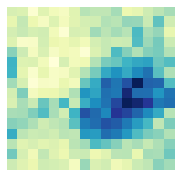

In [9]:
labels = labels_1
f = plt.figure(figsize=(3,3))
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
for i in range(som_dim[0]*som_dim[1]):
    s1 = np.sum(labels[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
plt.show()

### Trajectories

In [34]:
T = []
S = []
for i in range(1000):
    h = np.reshape(u_disc_6, (-1,72))
    if np.max(h[i]) == 1:
        T.append(i)
    else:
        S.append(i)

In [38]:
ind_r = np.random.random_integers(0, 50, 10)
ind_s = np.random.random_integers(0, 50, 10)
T = np.array(T)
S = np.array(S)
a = np.concatenate([S[ind_s], T[ind_r]])

<ipython-input-38-85dbe495fba2>:1: DeprecationWarning: This function is deprecated. Please call randint(0, 50 + 1) instead
  ind_r = np.random.random_integers(0, 50, 10)
<ipython-input-38-85dbe495fba2>:2: DeprecationWarning: This function is deprecated. Please call randint(0, 50 + 1) instead
  ind_s = np.random.random_integers(0, 50, 10)


In [39]:
k_all.shape

(1500, 72)

In [ ]:
labels = labels_1
it = 0
k_all = np.reshape(k_all, (-1,72))
fig, ax = plt.subplots(5, 4, figsize=(50,43)) 
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
for i in range(som_dim[0]*som_dim[1]):
    s1 = np.sum(labels[np.where(np.reshape(k_all, (-1)) == i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
for t in a:
    #fig, ax = plt.subplots(figsize=(10,7.5)) 
    if it > 9:
        c = "r"
        #print(t)
    else:
        c = "g"
    cc = it % 4
    rr = it // 4
    g = sns.heatmap(clust_matr1, cmap="YlGnBu",ax=ax[rr][cc])
    k_1 = k_all[t] // som_dim[1]
    k_2 = k_all[t] % som_dim[1]
    ax[rr][cc].plot(k_2[:] + 0.5, k_1[:] + 0.5, color=c, linewidth=4)
    ax[rr][cc].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=200, label='Start')
    ax[rr][cc].scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=5, marker='.')
    ax[rr][cc].scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=500, linewidth=4, marker='x', label='End')
    ax[rr][cc].legend(loc=2, prop={'size': 20})
    it +=1
plt.show()

Probability distribution over trajectory:

In [82]:
qq.shape

(108000, 256)

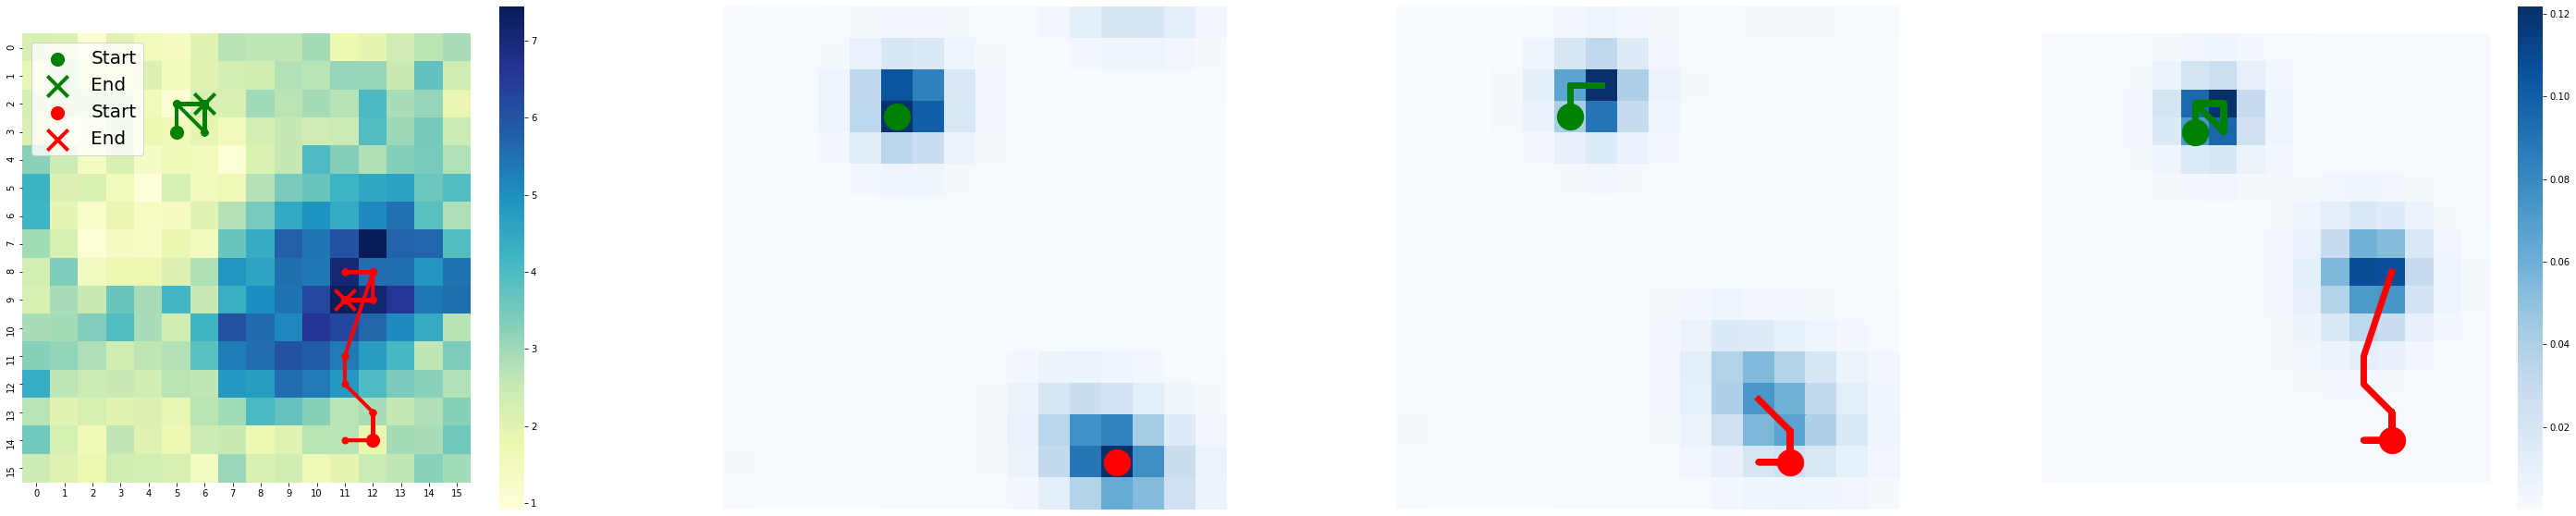

In [76]:
prob_q = np.reshape(qq, (-1, 72, som_dim[0]*som_dim[1])) 
i_g = np.random.randint(0, 50) #Randomly sampled patient
i_g = S[i_g]
i_r = np.random.randint(0, 50) #Randomly sampled patient
i_r = T[i_r]
t_g = [0, 20, 70]
t_r = [0, 20, 70]
fig, ax = plt.subplots(1, 4, figsize=(50,10))
k_all = np.reshape(k_all, (-1,72))

ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
for i in range(som_dim[0]*som_dim[1]):
    s1 = np.sum(labels[np.where(np.reshape(k_all, (-1)) == i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
g = sns.heatmap(clust_matr1, cmap="YlGnBu",ax=ax[0], square=True)
c="green"
k_1 = k_all[i_g] // som_dim[1]
k_2 = k_all[i_g] % som_dim[1]
ax[0].plot(k_2[:] + 0.5, k_1[:] + 0.5, color=c, linewidth=4)
ax[0].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=200, label='Start')
ax[0].scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=5, marker='.')
ax[0].scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=500, linewidth=4, marker='x', label='End')

c="red"
k_1 = k_all[i_r] // som_dim[1]
k_2 = k_all[i_r] % som_dim[1]
ax[0].plot(k_2[:] + 0.5, k_1[:] + 0.5, color=c, linewidth=4)
ax[0].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=200, label='Start')
ax[0].scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=5, marker='.')
ax[0].scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=500, linewidth=4, marker='x', label='End')
ax[0].legend(loc=2, prop={'size': 20})


for it in range(3):
    cc = it + 1
    k_1 = k_all[i_g] // som_dim[1]
    k_2 = k_all[i_g] % som_dim[1]
    t = t_g[it]
    aa = np.copy(prob_q[i_g, t])
    aa = aa /1.5
    ccb=False
    if it==2:
        ccb=True
    g1 = sns.heatmap(np.reshape(aa+prob_q[i_r, t_r[it]], (som_dim[0],som_dim[1])), cmap='Blues', alpha=1,  ax=ax[cc], cbar=ccb, xticklabels=False, yticklabels=False, square=True)
    ax[cc].plot(k_2[:t+1] + 0.5, k_1[:t+1] + 0.5, color="green", linewidth=7)
    ax[cc].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color="green", s=800)
    
    k_1 = k_all[i_r] // som_dim[1]
    k_2 = k_all[i_r] % som_dim[1]
    t = t_r[it]
    ax[cc].plot(k_2[:t+1] + 0.5, k_1[:t+1] + 0.5, color="red", linewidth=7)
    ax[cc].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color="red", s=800)

plt.show()

## Unrolling future time-steps and prediction

In [ ]:
def z_dist_flat(z_e, embeddings):
    """Computes the distances between the encodings and the embeddings."""
    emb = np.reshape(embeddings, (som_dim[0]*som_dim[1], -1))
    z = np.reshape(z_e, (z_e.shape[0], 1, latent_dim))
    z = np.tile(z, [1,som_dim[0]*som_dim[1], 1])
    z_dist = np.square(z-emb)
    z_dist_red = np.sum(z_dist, axis=-1)
    return z_dist_red

In [ ]:
val_gen = batch_generator(data_train, data_val, endpoints_total_val, 300, mode="val")

In [ ]:
tf.reset_default_graph()
num_batches = len(data_val) // 300
latent_dim = 20
num_pred = 6
som = 16*16
max_n_step = 72
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath+".meta")
    saver.restore(sess, modelpath)
    graph = tf.get_default_graph()
    k = graph.get_tensor_by_name("k/k:0")
    z_e = graph.get_tensor_by_name("z_e_sample/z_e:0")
    next_z_e = graph.get_tensor_by_name("prediction/next_z_e:0")
    x = graph.get_tensor_by_name("inputs/x:0")
    is_training = graph.get_tensor_by_name("is_training/is_training:0")
    graph = tf.get_default_graph()
    init_1 = graph.get_tensor_by_name("prediction/next_state/init_state:0")
    z_e_p = graph.get_tensor_by_name("prediction/next_state/input_lstm:0")
    state1 = graph.get_tensor_by_name("prediction/next_state/next_state:0")
    q = graph.get_tensor_by_name("q/distribution/q:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")
    z_p = graph.get_tensor_by_name('reconstruction_e/decoder/z_e:0')
    reconstruction = graph.get_tensor_by_name("reconstruction_e/x_hat:0")
    
    print("Evaluation...")
    training_dic = {is_training: True, z_e_p: np.zeros((max_n_step * len(data_val), latent_dim)),
                    init_1: np.zeros((2, batch_size, 100)), z_p: np.zeros((max_n_step * len(data_val), latent_dim))}
    k_all = []
    z_e_all=[]
    z_q_all = []
    qq = []
    x_rec = []
    for i in range(num_batches):
            batch_data, batch_labels, ii = next(val_gen)
            f_dic = {x: batch_data}
            k_all.extend(sess.run(k, feed_dict=f_dic))
            z_q_all.extend(sess.run(q, feed_dict=f_dic))
            z_e_all.extend(sess.run(z_e, feed_dict=f_dic))
            qq.extend(sess.run(q, feed_dict=f_dic))
            f_dic.update(training_dic)
            x_rec.extend(sess.run(reconstruction, feed_dict=f_dic))
    z_e_all = np.array(z_e_all)
    k_all = np.array(k_all)
    qq = np.array(qq)
    x_rec = np.array(x_rec)
    z_e_all = z_e_all.reshape((-1, max_n_step, latent_dim))
    k_all = k_all.reshape((-1, max_n_step))
    
    t = 72-num_pred
    
    embeddings = sess.run(embeddings, feed_dict={x: data_val[:, :t, :]})
    embeddings = np.reshape(embeddings,(-1, latent_dim))
    
    z_e_o = z_e_all[:, :t, :]
    k_o = k_all[:, :t]
    k_eval=[]
    next_z_e_o = []
    state1_o =[]
    for i in range(num_batches):
        batch_data, batch_labels, ii = next(val_gen)
        batch_data=batch_data[:, :t, :]
        f_dic = {x: batch_data}
        f_dic.update(training_dic)
        next_z_e_o.extend(sess.run(next_z_e, feed_dict=f_dic))
        if i == 0:
            state1_o = sess.run(state1, feed_dict=f_dic)
        else:
            state1_o = np.concatenate([state1_o, sess.run(state1, feed_dict=f_dic)], axis=1)
    next_z_e_o = np.array(next_z_e_o)
    state1_o = np.array(state1_o)
    
    next_z_e_o_all = np.reshape(next_z_e_o[:, -1, :], (-1,1,latent_dim))
    next_z_e_o = next_z_e_o[:, -1, :]
    k_next = np.argmin(z_dist_flat(next_z_e_o, embeddings), axis=-1)
    k_o = np.concatenate([k_o, np.expand_dims(k_next,1)], axis=1)
    z_e_o = np.concatenate([z_e_o, np.expand_dims(next_z_e_o, 1)], axis=1)
    f_dic = {x: np.zeros((len(data_val),1, 98)), is_training: False, z_e_p: np.zeros((1 * len(data_val), latent_dim)),
             z_p: next_z_e_o, init_1: np.zeros((2, batch_size, 100))}
    x_pred_hat = np.reshape(sess.run(reconstruction, feed_dict=f_dic), (-1, 1, 98))
    
    for i in range(num_pred-1):
        print(i)
        inp = data_val[:1500, (t + i), :]
        f_dic = {x: np.reshape(inp, (inp.shape[0],1,inp.shape[1]))}
        val_dic = {is_training: False, z_e_p: next_z_e_o, init_1: state1_o, z_p: np.zeros((max_n_step * len(inp), latent_dim))}
        f_dic.update(val_dic)
        next_z_e_o = sess.run(next_z_e, feed_dict=f_dic)
        state1_o = sess.run(state1, feed_dict=f_dic)
        next_z_e_o_all = np.concatenate([next_z_e_o_all, next_z_e_o], axis=1)
        k_next = np.argmin(z_dist_flat(next_z_e_o, embeddings), axis=-1)
        k_o = np.concatenate([k_o, np.expand_dims(k_next,1)], axis=1)
        z_e_o = np.concatenate([z_e_o, next_z_e_o], axis=1)
        next_z_e_o = np.reshape(next_z_e_o, (-1, latent_dim))
        f_dic = {x: np.zeros((len(data_val),1, 98)), is_training: False, z_e_p: np.zeros((max_n_step * len(data_val), latent_dim)),
             z_p: next_z_e_o, init_1: np.zeros((2, batch_size, 100))}
        final_x = sess.run(reconstruction, feed_dict=f_dic)
        x_pred_hat = np.concatenate([x_pred_hat, np.reshape(final_x, (-1, 1, 98))], axis = 1)
    
    f_dic = {x: np.zeros((1500,1, 98)), is_training: False, z_e_p: np.zeros((max_n_step * 1500, latent_dim)),
             z_p: z_e_all[:, t-1, :], init_1: np.zeros((2, batch_size, 100))}
    final_x = sess.run(reconstruction, feed_dict=f_dic)

In [ ]:
sklearn.metrics.mean_squared_error(np.reshape(x_pred_hat, (-1, 98)), np.reshape(data_val[:1500, -num_pred:], (-1, 98)))

Accuracy of unrolled state:

In [ ]:
k_true = np.reshape(k_all[:, -num_pred:], (-1))
k_pred = np.reshape(k_o[:, -num_pred:], (-1))
tot = 0
acc = 0
for i in range(len(k_true)):
    tot += 1
    if k_true[i] == k_pred[i]:
        acc += 1
acc = acc / tot
acc

# LSTM baseline

In [ ]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM

data_train, data_val, endpoints_total_train, endpoints_total_val = get_data(test=True)
labels_train= np.concatenate((data_train[:, 1:], np.reshape(data_train[:, -1], (-1,1, 98))), axis=1)

model = Sequential()
model.add(LSTM(98, activation='relu', input_shape=(None, 98), return_sequences=True))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(data_train, labels_train, epochs=100, batch_size=300, verbose=0)

test_data = data_val[:, :-6]
for i in range(6):
    a = model.predict(test_data)
    test_data = np.concatenate((test_data, np.reshape(a[:,-1,:], (-1, 1, 98))), axis=1)

mean_squared_error(np.reshape(test_data[:,-6:],(-1)), np.reshape(data_val[:,-6:],(-1)))